##                                                Deep Learning PROJECT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## The goal of this notebook is to introduce sequence to sequence language translation (seq2seq).
The notebook deals with a sequence to sequence model for English to Hindi translation. After training the model one will be able to input a English sentence and get back its Hindi translation.

>RNNs are also capable of doing natural language translation, aka. machine translation. It involves two RNNs, one for the source language and one for the target language. One of them is called an encoder, and the other one decoder. The reason is that, the first one encodes the sentence into a vector and the second one converts the encoded vector into a sentence in target language. The decoder is a separete RNN. Given the encoded sentence, it produces the translated sentence in target language. Attention lets the decoder to focus on specific parts of the input sentence for each output word. This helps the input and output sentences to align with one another.

We obtained the dataset used from Kaggle: https://www.kaggle.com/aiswaryaramachandran/hindienglish-corpora

<h2> References: </h2>
<li></a> Sequence to Sequence Learning with Neural Networks (Research Publication)</li>
<li></a> https://www.tensorflow.org/tutorials/text/nmt_with_attention </li>
<li></a> Using stochastic computation graphs formalism for optimization of sequence-to-sequence model (Research Publication) </li>
</ul>

### Import libraries

In [ ]:
!pip install fasteda

  Preparing metadata (setup.py) ... done
  Created wheel for fasteda: filename=fasteda-1.0.1-py3-none-any.whl size=4740 sha256=bbbabb4bd3490760e0465ec390eb70a0b790e65924b4c678298f94df062c053d
  Stored in directory: /root/.cache/pip/wheels/4f/13/ff/0dd443dbccb4aeb12e299f90c9f47d758d893fd26c22537443
Successfully built fasteda


In [ ]:
import os
import string
import numpy as np
import pandas as pd
import seaborn as sns
from string import digits
import matplotlib.pyplot as plt
from fasteda import fast_eda
%matplotlib inline
import re
from collections import Counter
import cufflinks as cf
import logging
import tensorflow as tf
#tf.enable_eager_execution()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import io
import time
import warnings
import sys


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

PATH = "/kaggle/input/hindienglish-corpora/Hindi_English_Truncated_Corpus.csv"

/kaggle/input/hindienglish-corpora/Hindi_English_Truncated_Corpus.csv
/kaggle/input/english-to-hindi-neural-machine-translation/X_test.pkl
/kaggle/input/english-to-hindi-neural-machine-translation/nmt_weights.h5
/kaggle/input/english-to-hindi-neural-machine-translation/__results__.html
/kaggle/input/english-to-hindi-neural-machine-translation/X_train.pkl
/kaggle/input/english-to-hindi-neural-machine-translation/__notebook__.ipynb
/kaggle/input/english-to-hindi-neural-machine-translation/__output__.json
/kaggle/input/english-to-hindi-neural-machine-translation/custom.css


## Dataframe Info

In [ ]:
data = pd.read_csv(PATH)

In [ ]:
data.head()

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127607 entries, 0 to 127606
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   source            127607 non-null  object
 1   english_sentence  127605 non-null  object
 2   hindi_sentence    127607 non-null  object
dtypes: object(3)
memory usage: 2.9+ MB


## Exploratory data analysis

In [ ]:
data.isna().sum()

source              0
english_sentence    2
hindi_sentence      0
dtype: int64

## Dropping missing values

In [ ]:
data = data.dropna()

In [ ]:
# checking null values
data.isna().sum()

source              0
english_sentence    0
hindi_sentence      0
dtype: int64

In [ ]:
# counting sources
data['source'].value_counts()

tides        50000
ted          39881
indic2012    37724
Name: source, dtype: int64

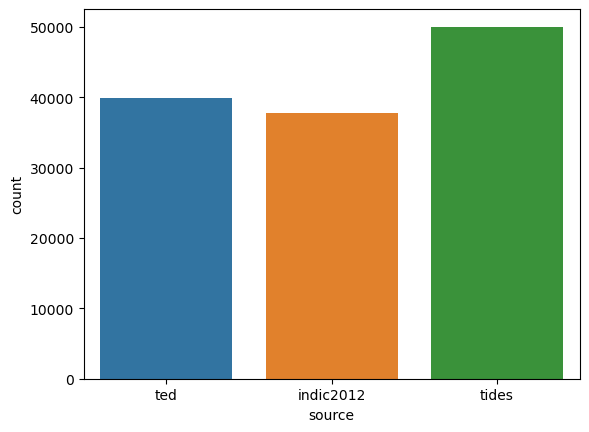

In [ ]:
sns.countplot(x = data['source'],data = data)
plt.show()

In [ ]:
# checking duplicated data
isDuplicated = data.duplicated().any()
if isDuplicated:
    total_duplicates = data.duplicated().sum()
    print("Total duplicate rows are: ",total_duplicates)
    data.drop_duplicates(inplace = True)

Total duplicate rows are:  2778


In [ ]:
## sampling 20000 rows randomly
data = data.sample(n = 20000, random_state = 31)
data.shape

(20000, 3)

## Preprocess English and Hindi sentences

In [ ]:
## changing uppercase to lowercase
data['english_sentence'] = data['english_sentence'].apply(lambda x: x.lower())
data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: x.lower())

# Remove quotes
data['english_sentence']=data['english_sentence'].apply(lambda x: re.sub("'", '', x))
data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: re.sub("'", '', x))


In [ ]:
to_exclude = set(string.punctuation) # Set of all special characters
print("punctuations to exclude:: ",to_exclude)
# Remove all the special characters
data['english_sentence']=data['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in to_exclude))
data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in to_exclude))

punctuations to exclude::  {'~', '_', '#', '\\', ']', '}', '@', '`', '=', '?', '!', '>', ')', '&', '{', '/', '[', ':', '(', '|', ',', '+', '.', ';', "'", '*', '$', '<', '%', '"', '^', '-'}


In [ ]:
from string import digits
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)

data['english_sentence']=data['english_sentence'].apply(lambda x: x.translate(remove_digits))
data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: x.translate(remove_digits))

data['hindi_sentence'] = data['hindi_sentence'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

# Remove extra spaces
data['english_sentence']=data['english_sentence'].apply(lambda x: x.strip())
data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: x.strip())
data['english_sentence']=data['english_sentence'].apply(lambda x: re.sub(" +", " ", x))
data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: re.sub(" +", " ", x))

In [ ]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()
    return w

def hindi_preprocess_sentence(w):
    w = w.rstrip().strip()
    return w

In [ ]:
def create_dataset(path=PATH):
    lines=pd.read_csv(path,encoding='utf-8')
    lines=lines.dropna()
    lines = lines[lines['source']=='ted']
    en = []
    hd = []
    for i, j in zip(lines['english_sentence'], lines['hindi_sentence']):
        en_1 = [preprocess_sentence(w) for w in i.split(' ')]
        en_1.append('<end>')
        en_1.insert(0, '<start>')
        hd_1 = [hindi_preprocess_sentence(w) for w in j.split(' ')]
        hd_1.append('<end>')
        hd_1.insert(0, '<start>')
        en.append(en_1)
        hd.append(hd_1)
    return hd, en

In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

## Most Common Words

In [ ]:
tot_eng_sen = ""
for eng_sent in data["english_sentence"].tolist():
    tot_eng_sen += eng_sent + " "

Counter(tot_eng_sen.split(" ")).most_common(10)

[('the', 20967),
 ('of', 11934),
 ('and', 9388),
 ('to', 7679),
 ('in', 7634),
 ('a', 5844),
 ('is', 4776),
 ('that', 2973),
 ('for', 2570),
 ('was', 2566)]

In [ ]:
tot_hindi_sen = ""
for hin_sent in data["hindi_sentence"].tolist():
    tot_hindi_sen += hin_sent + " "

Counter(tot_hindi_sen.split(" ")).most_common(10)

[('के', 14009),
 ('में', 10320),
 ('है', 9128),
 ('की', 7990),
 ('और', 7466),
 ('से', 6024),
 ('का', 5324),
 ('को', 5078),
 ('हैं', 3915),
 ('एक', 3255)]

In [ ]:
cf.set_config_file(offline=True)
data["eng_char_count"] = data["english_sentence"].str.len()
data["hindi_char_count"] = data["hindi_sentence"].str.len()
data["hindi_tok_count"] = data["hindi_sentence"].str.split(" ").str.len()
data["eng_tok_count"] = data["english_sentence"].str.split(" ").str.len()

DataFrame Head:


,source,eng_char_count,hindi_char_count,hindi_tok_count,eng_tok_count
114258,indic2012,68,61,14,12
157,tides,96,108,25,15
118862,tides,184,198,36,36


DataFrame Tail:


,source,eng_char_count,hindi_char_count,hindi_tok_count,eng_tok_count
50214,tides,74,74,16,14
98031,indic2012,136,160,28,26
6633,ted,27,25,5,4


----------------------------------------------------------------------------------------------------
Missing values:


,0


----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(20000, 5)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 114258 to 6633
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   source            20000 non-null  object
 1   eng_char_count    20000 non-null  int64 
 2   hindi_char_count  20000 non-null  int64 
 3   hindi_tok_count   20000 non-null  int64 
 4   eng_tok_count     20000 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 937.5+ KB
----------------------------------------------------------------------------------------------------
Describe DataFrame:



,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
eng_char_count,20000,87.284,64,81.771,0,38,64,115,2132,5.388768,74.332999
hindi_char_count,20000,86.476,64,83.16,0,37,64,112,2025,5.224880,64.119769
hindi_tok_count,20000,17.162,13,16.065,1,8,13,22,417,5.544912,75.712576
eng_tok_count,20000,15.334,12,14.093,1,7,12,20,398,5.844470,91.221852


----------------------------------------------------------------------------------------------------
DataFrame Correlation:



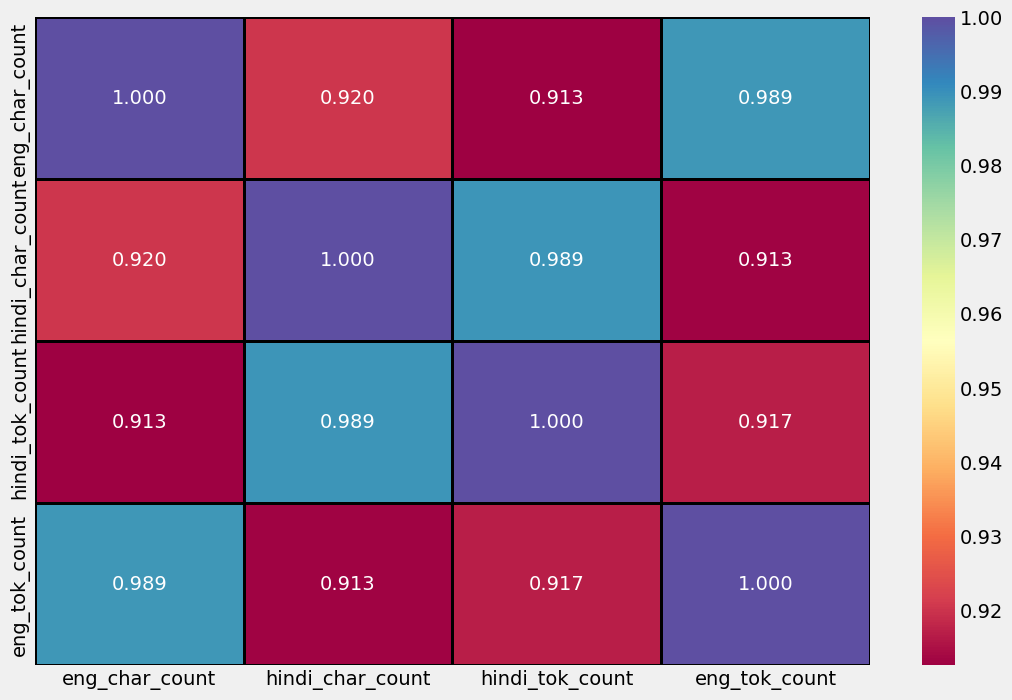

----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



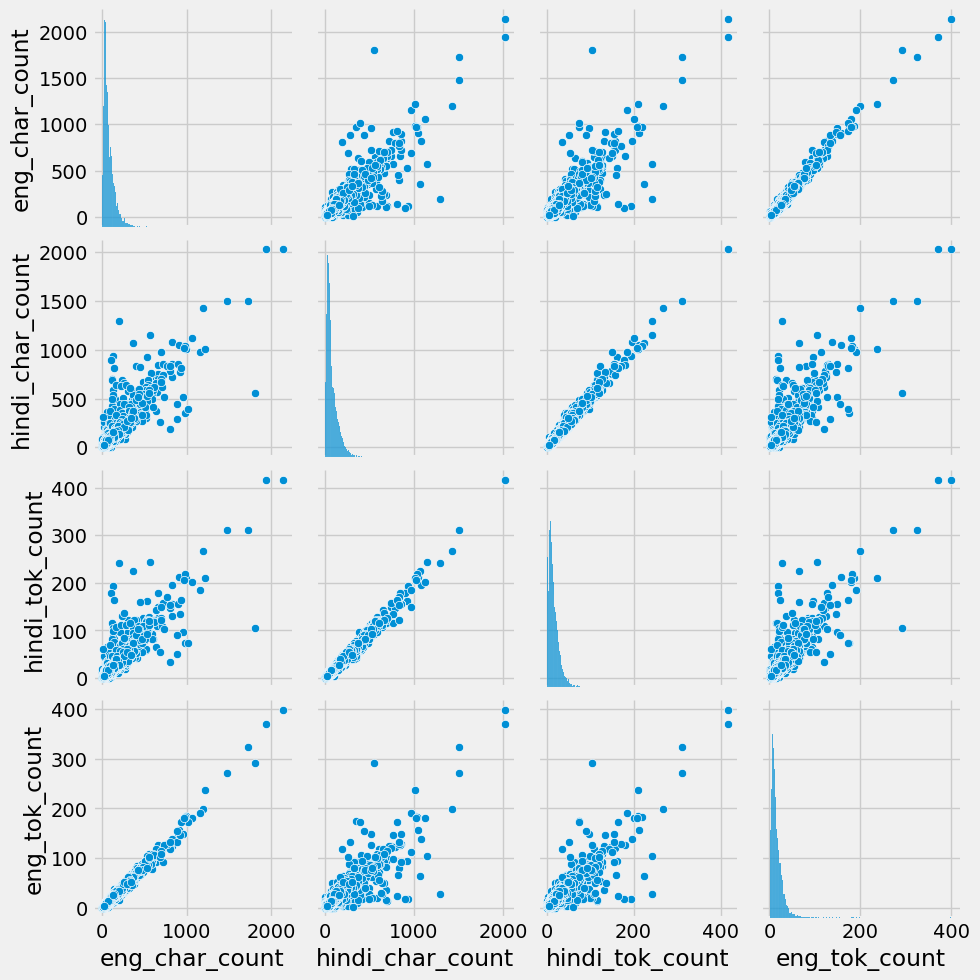

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



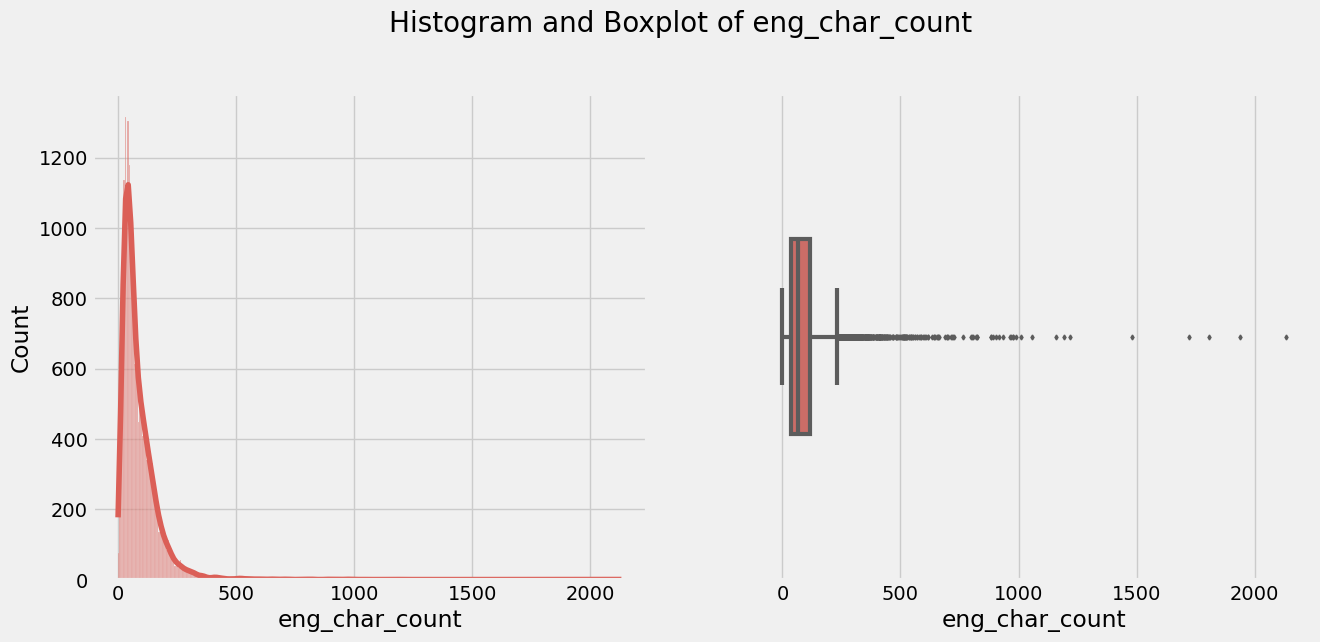

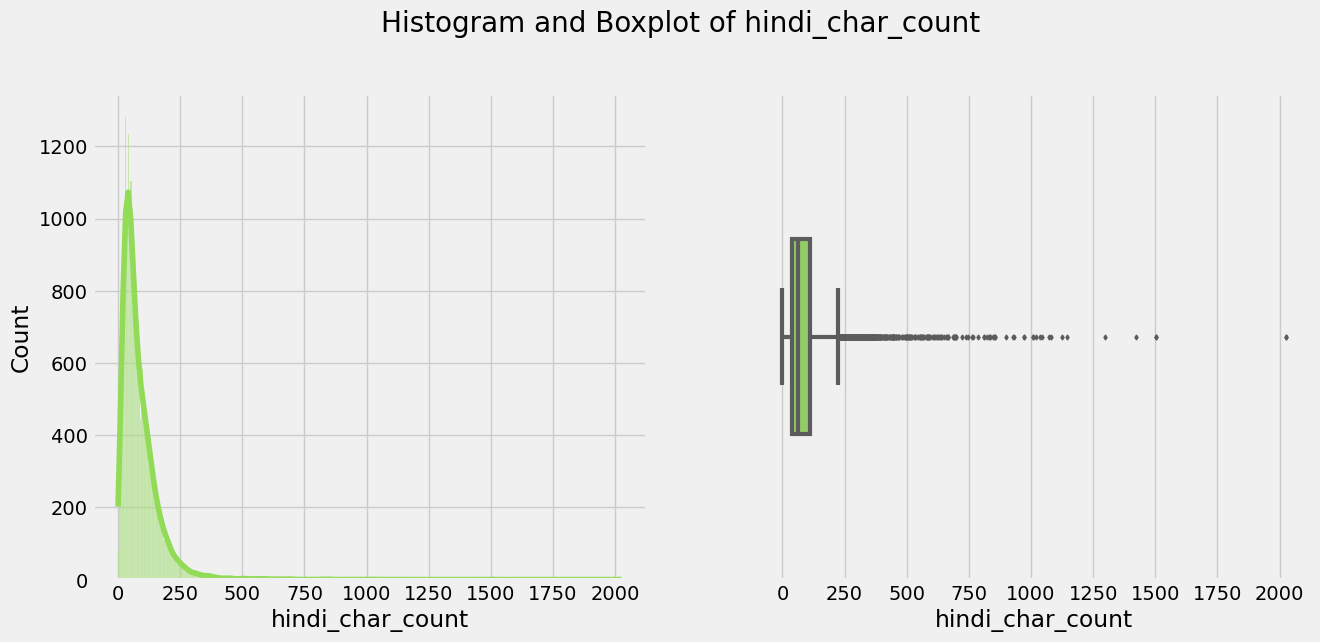

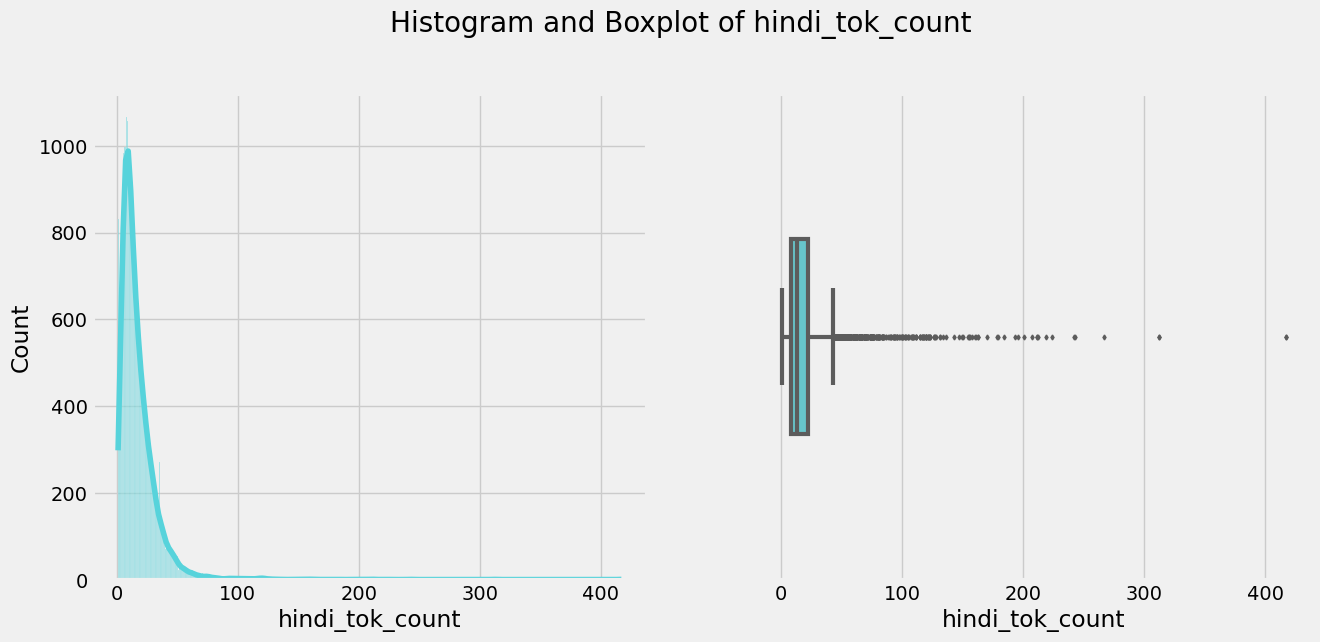

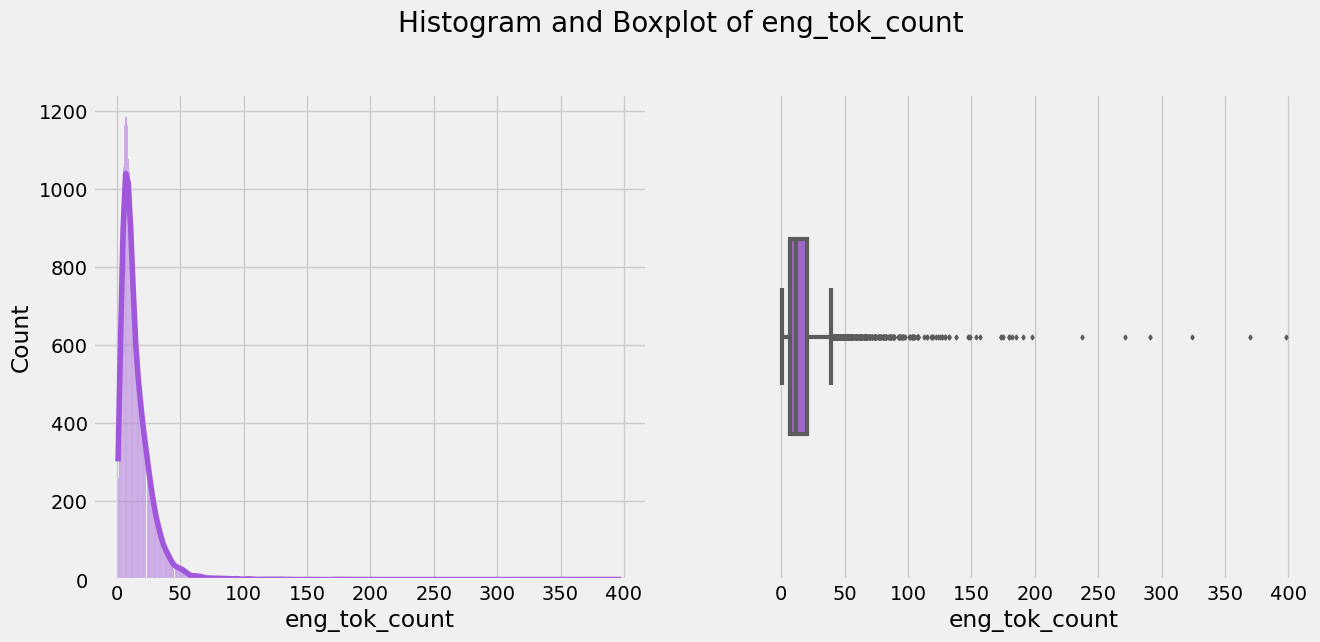

----------------------------------------------------------------------------------------------------
Countplot(s):



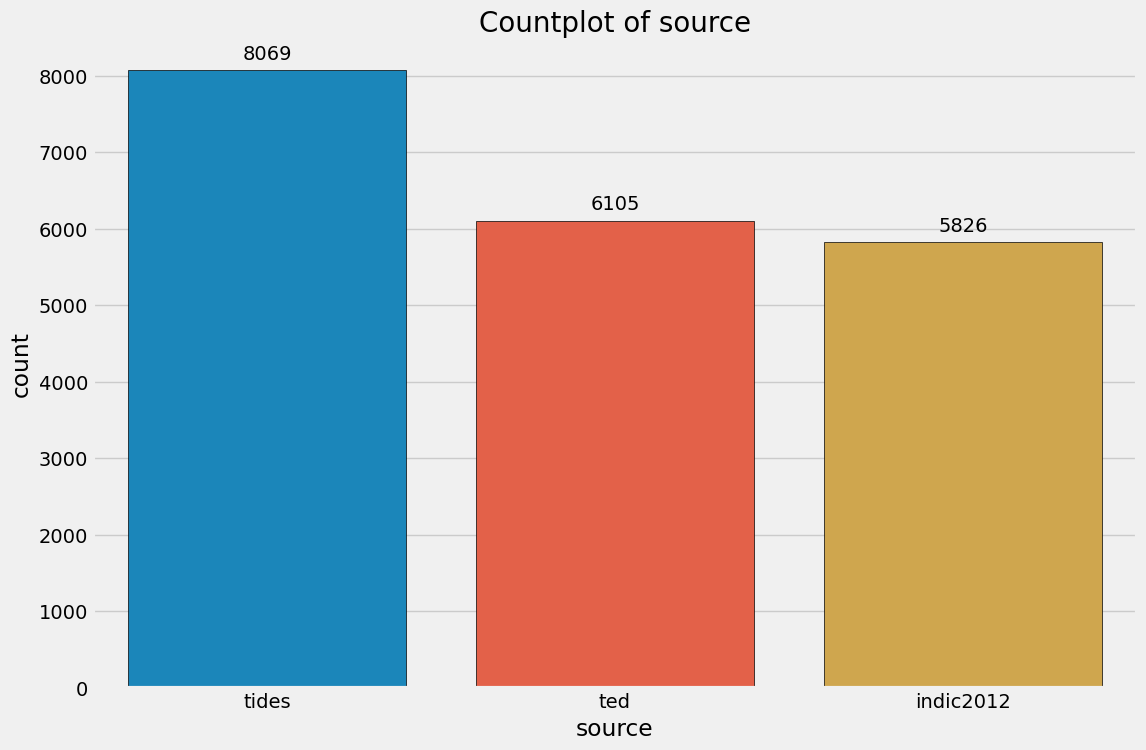

In [ ]:
fast_eda(data[["source", "eng_char_count", 	"hindi_char_count", 	"hindi_tok_count", 	"eng_tok_count",]])

### Tokenization of the data

In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path=PATH):
    targ_lang, inp_lang = create_dataset(path)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(PATH)
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

### Create Train and Test dataset

In [ ]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

31904 31904 7977 7977


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping

1 ----> <start>

126 ----> why

7 ----> a

120 ----> lot

6 ----> of

40 ----> people

19 ----> have

2547 ----> trouble

573 ----> seeing

895 ----> themselves

32 ----> as

2103 ----> leaders .

2 ----> <end>



Target Language; index to word mapping

1 ----> <start>

199 ----> क्यों

31 ----> बहुत

181 ----> सारे

66 ----> लोग

210 ----> खुद

11 ----> को

1085 ----> नेतृत्व

4 ----> के

2354 ----> काबिल

15 ----> नहीं

764 ----> समझते

52 ----> हैं।

2 ----> <end>


### Create Dataset
> We are using minimal configuration as the notebbok is not focussed on metrics performance but rather the implementation.

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 128
units = 256
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

## Encoder Decoder with Attention Model

> Encoder Decoder with Attention model is a general end-to-end approach to sequence learning that makes minimal assumptions on the sequence structure. It uses a multilayered Gated Recurrent Unit (GRU) to map the input sequence to a vector of a fixed dimensionality, and then another deep GRU to decode the target sequence from the vector.

<img src="https://www.researchgate.net/profile/Vlad_Zhukov2/publication/321210603/figure/fig1/AS:642862530191361@1530281779831/An-example-of-sequence-to-sequence-model-with-attention-Calculation-of-cross-entropy.png" width="800" alt="attention mechanism">


> A sequence to sequence model has two parts – an encoder and a decoder. Both the parts are practically two different neural network models combined into one giant network. the task of an encoder network is to understand the input sequence, and create a smaller dimensional representation of it. This representation is then forwarded to a decoder network which generates a sequence of its own that represents the output. The input is put through an encoder model which gives us the encoder output. Here, each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. We use Bahdanau attention for the encoder.

### Encoder

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

### Attention Mechanism

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    hidden_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

### Decoder

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)
    return x, state, attention_weights

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

### Optimizer

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
#   print(type(mask))
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

>1. Pass *input* through *encoder* to get *encoder output*..
>2. Then encoder output, encoder hidden state and the decoder input is passed to decoder.
>3. Decoder returns *predictions* and *decoder hidden state*.
>4. Decoder hidden state is then passed back to model.
>5. Predictions are used to calculate loss.
>6. Use *teacher forcing* (technique where the target word is passed as the next input to the decoder) for the next input to the decoder.
>7. Calculate gradients and apply it to *optimizer* for backpropogation.

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
    # Teacher forcing
    for t in range(1, targ.shape[1]):
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.0074

Epoch 1 Batch 100 Loss 1.8105

Epoch 1 Batch 200 Loss 1.8504

Epoch 1 Batch 300 Loss 2.0275

Epoch 1 Batch 400 Loss 1.8270

Epoch 1 Loss 1.8810

Time taken for 1 epoch 2271.0630321502686 sec



Epoch 2 Batch 0 Loss 1.7851

Epoch 2 Batch 100 Loss 1.6902

Epoch 2 Batch 200 Loss 1.8486

Epoch 2 Batch 300 Loss 1.7605

Epoch 2 Batch 400 Loss 1.6085

Epoch 2 Loss 1.7220

Time taken for 1 epoch 2210.1156113147736 sec



Epoch 3 Batch 0 Loss 1.6501

Epoch 3 Batch 100 Loss 1.5824

Epoch 3 Batch 200 Loss 1.5858

Epoch 3 Batch 300 Loss 1.4958

Epoch 3 Batch 400 Loss 1.6879

Epoch 3 Loss 1.6240

Time taken for 1 epoch 2227.5665616989136 sec



Epoch 4 Batch 0 Loss 1.5278

Epoch 4 Batch 100 Loss 1.4338

Epoch 4 Batch 200 Loss 1.5110

Epoch 4 Batch 300 Loss 1.4896

Epoch 4 Batch 400 Loss 1.5147

Epoch 4 Loss 1.5385

Time taken for 1 epoch 2228.113371372223 sec



Epoch 5 Batch 0 Loss 1.4927

Epoch 5 Batch 100 Loss 1.5621

Epoch 5 Batch 200 Loss 1.4523

Epoch 5 Batch 300 

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence

In [ ]:
def translate(sentence):
    result, sentence = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
translate(u'politicians do not have permission to do what needs to be done.')

Input: politicians do not have permission to do what needs to be done .

Predicted translation: वो नहीं है कि यह नहीं है कि वो नहीं है । <end> 
